# Lid-driven cavity flow example
This is an example of using the cavity flow
A two dimensional flow is initialized and simulated. Afterwards, the energy and the velocity field are plotted.

In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import os

## Setup
* for running on GPU: device = "cuda". CUDA drivers are required!
* dtype=torch.float32 for single precision - float64 for double precision
* select collision model (here BGKCollision) - try also KBCCollision or RegularizedCollision

### Code:
* Reporter will grab the results in between simulation steps
* Output: Column 1: simulation steps, Column 2: time in LU, Column 3: kinetic energy in PU
* Output: separate VTK-file with ux,uy,(uz) and p for every 100. time step in ./output

In [2]:
nmax     = 100000
nconsole = 1000
nreport  = 100
epsilon  = 0.0001 # convergence condition: .1 % relative change
Re = 100

context = lt.Context(use_native=False)
flow = lt.Cavity2D(context=context, resolution=64, reynolds_number=Re, mach_number=0.05)
simulation = lt.Simulation(flow=flow, collision=lt.KBCCollision(), reporter=[])

Energy = lt.IncompressibleKineticEnergy(flow)
energy_reporter_internal = lt.ObservableReporter(Energy, interval=nreport, out=None)
simulation.reporter.append(energy_reporter_internal)
simulation.reporter.append(lt.ObservableReporter(Energy, interval=nconsole)) # print energy
if not os.path.isdir("data"):
    os.mkdir("data")
simulation.reporter.append(lt.VTKReporter(interval=nreport, filename_base=f"./data/cavity2d_Re{Re}/out"))

steps     time     IncompressibleKineticEnergy
steps     time     IncompressibleKineticEnergy


## Run simulations

In [3]:
energy_new = 0
mlups = 0
iterations = int(nmax//nconsole)
for _ in range(iterations):
    energy_old = energy_new
    energy_new = Energy(flow.f).mean()
    mlups += simulation(nconsole)
    if abs((energy_new - energy_old)/energy_new) < epsilon:
        print("CONVERGENCE! Less than ", epsilon*100, " % relative change")
        break
    if not energy_new == energy_new:
        print("CRASH")
        break
print("avg MLUPS: ", mlups/iterations)

0 0.0 0.0
1000 0.45105489780439517 0.019674744457006454
2000 0.9021097956087903 0.02419084496796131
3000 1.3531646934131856 0.0268400888890028
4000 1.8042195912175807 0.028614206239581108
5000 2.255274489021976 0.029889840632677078
6000 2.706329386826371 0.030847690999507904
7000 3.157384284630766 0.031584933400154114
8000 3.6084391824351614 0.0321597158908844
9000 4.059494080239556 0.03261049836874008
10000 4.510548978043952 0.03296438604593277
11000 4.961603875848347 0.03324209898710251
12000 5.412658773652742 0.033459488302469254
13000 5.863713671457138 0.033629387617111206
14000 6.314768569261532 0.03376169875264168
15000 6.765823467065927 0.03386494889855385
16000 7.216878364870323 0.03394544497132301
17000 7.667933262674718 0.03400781750679016
18000 8.118988160479113 0.034056372940540314
19000 8.570043058283508 0.034093745052814484
20000 9.021097956087903 0.034122712910175323
21000 9.472152853892299 0.034145306795835495
22000 9.923207751696694 0.034162867814302444
23000 10.374262

## Post process
### Energy Reporter
* Grab output of kinetic energy reporter

(301, 3)


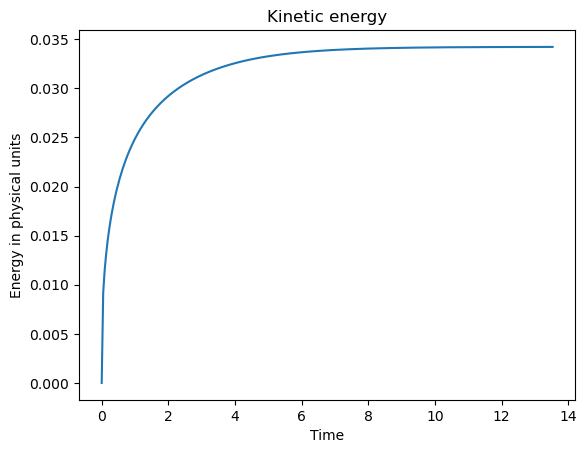

In [4]:
energy = np.array(simulation.reporter[0].out)
print(energy.shape)
plt.plot(energy[:,1],energy[:,2])
plt.title('Kinetic energy')
plt.xlabel('Time')
plt.ylabel('Energy in physical units')
plt.show()

### Velocity
We calculate the speed in Lettuce units depending on the last 'f'. Then we convert this velocity into physical units. For further investigations the tensor must be converted into a Numpy-Array. The norm of the fractions in x and y direction is plotted afterwards.

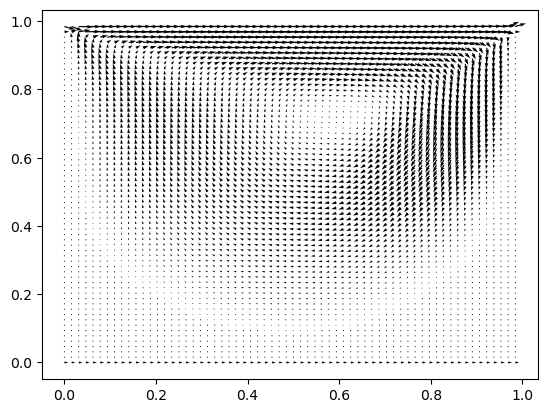

In [5]:
u_x, u_y = context.convert_to_ndarray(flow.u_pu)
x, y = [context.convert_to_ndarray(_) for _ in flow.grid]
plt.quiver(x.T, y.T, u_x.T, u_y.T)